# Feature engineering

In [1]:
import os 
import gc 
import numpy as np 
import pandas as pd 
import json 
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

warnings.simplefilter('ignore')

/usr/local/miniconda3/envs/py36/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [69]:

def load_data(path, nrows=None):

    json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(path, dtype={
        'fullVisitorId': 'str', 'visitId': 'str'}, 
        nrows=nrows,
        converters={column: json.loads for column in json_cols},
        engine="c")

    for col in json_cols:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f'{col}.{subcolumn}' 
            for subcolumn in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    
    print(f"Loaded {os.path.basename(path)}, data shape: {df.shape}")
    return df 


def tidy_data(df):

    # Convert target into log scale
    y_name = 'totals.transactionRevenue'
    df[y_name] = df[y_name].astype(float).fillna(0)
    df[y_name+'_log'] = np.log1p(df[y_name])

    # Remove columns that has const value. May be indicate blank value
    na_vals = ['unknown.unknown', '(not set)', 'not available in demo dataset', 
        '(not provided)', '(none)', '<NA>']
    for c in df.columns:
        is_na = df[c].isin(na_vals)
        df.loc[is_na, c] = np.nan
    const_cols = [c for c in df.columns if df[c].notnull().sum() == 0]
    print(f"Only NA value column list: {const_cols}")
    df.drop(const_cols, axis=1, inplace=True)

    # Drop duplicate meaning of columns
    # Todo: date column could be add to test
    sc = ['date', 'sessionId', 'socialEngagementType']
    print(f"No use columns: {sc}")
    df.drop(sc, axis=1, inplace=True)

    # Convert to should-be-like dtype
    df['visitStartTime'] = pd.to_datetime(
        df['visitStartTime'].astype(int).astype(str), unit='s')

    df['visitId'] = df['visitId'].astype("int64")
    
    # device section
    df['device.isMobile'] = df['device.isMobile'].astype("int8")

    # totals section
    sc = [c for c in df.columns if c.startswith('totals.')]
    for c in sc:
        df[c] = df[c].astype(float)

    # trafficSource section
    # sc = [c for c in df.columns if c.startswith("trafficSource")]

    return df


In [70]:
    DBG = True
    np.random.seed(123)
    nrows = 10000 if DBG else None

    train = load_data('../input/train.csv', nrows)
    sc = ['fullVisitorId', 'visitStartTime']
    train = train.sort_values(sc).reset_index(drop=True)
    test = load_data('../input/test.csv', nrows)
    test = test.sort_values(sc).reset_index(drop=True)

    y_name = 'totals.transactionRevenue'
    test[y_name] = 0
    tr_n = train.shape[0]
    train = train[test.columns.tolist()]
    # train = train.append(test, ignore_index=True)
    # How much visitor intersect between train and test dataset?
    train_user = set(train["fullVisitorId"].tolist())
    test_user = set(test["fullVisitorId"].tolist())
    cm_user = train_user & test_user
    idx = (train["fullVisitorId"].isin(cm_user)) & (pd.to_numeric(train[y_name]) > 0)
    print(f"train user count: {len(train_user)}, test user count: {len(test_user)},\n\
Common user cnt: {len(cm_user)} and common user with revenue count: {idx.sum()}")
    #df = train.append(test, ignore_index=True)
    df = train
    print(f"current data shape: {df.shape}")
    # del train, test
    gc.collect()

Loaded train.csv, data shape: (10000, 54)
Loaded test.csv, data shape: (10000, 53)
train user count: 9251, test user count: 9142,
Common user cnt: 9 and common user with revenue count: 0
current data shape: (10000, 54)


105

In [71]:
df = tidy_data(df)
df.describe()

Only NA value column list: ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'trafficSource.adwordsClickInfo.criteriaParameters']
No use columns: ['date', 'sessionId', 'socialEngagementType']


,visitId,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,totals.transactionRevenue,totals.transactionRevenue_log
count,1.000000e+04,10000.000000,10000.000000,5318.0,10000.000000,7701.0,10000.00000,10000.0,1.000000e+04,10000.000000
mean,1.485622e+09,2.167300,0.288600,1.0,4.224900,1.0,3.55770,1.0,1.065414e+06,0.161706
std,8.864598e+06,7.862283,0.453134,0.0,8.505819,0.0,6.21121,0.0,1.991012e+07,1.691880
min,1.472799e+09,1.000000,0.000000,1.0,1.000000,1.0,1.00000,1.0,0.000000e+00,0.000000
25%,1.472880e+09,1.000000,0.000000,1.0,1.000000,1.0,1.00000,1.0,0.000000e+00,0.000000
50%,1.486122e+09,1.000000,0.000000,1.0,1.000000,1.0,1.00000,1.0,0.000000e+00,0.000000
75%,1.489368e+09,1.000000,1.000000,1.0,3.000000,1.0,3.00000,1.0,0.000000e+00,0.000000
max,1.498288e+09,317.000000,1.000000,1.0,189.000000,1.0,138.00000,1.0,1.077000e+09,20.797445


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
channelGrouping                                 10000 non-null object
fullVisitorId                                   10000 non-null object
visitId                                         10000 non-null int64
visitNumber                                     10000 non-null float64
visitStartTime                                  10000 non-null datetime64[ns]
device.browser                                  10000 non-null object
device.deviceCategory                           10000 non-null object
device.isMobile                                 10000 non-null int8
device.operatingSystem                          9952 non-null object
geoNetwork.city                                 3748 non-null object
geoNetwork.continent                            9987 non-null object
geoNetwork.country                              9987 non-null object
geoNetwork.metro                                21

In [72]:
df.head()

,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,...,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,totals.transactionRevenue,totals.transactionRevenue_log
0,Social,0000245437374675368,1472862842,1.0,2016-09-03 00:34:02,Internet Explorer,desktop,0,Windows,NaN,...,NaN,NaN,NaN,NaN,NaN,referral,/yt/about/,youtube.com,0.0,0.0
1,Organic Search,0000750929315523353,1486157741,1.0,2017-02-03 21:35:41,Safari,desktop,0,Macintosh,NaN,...,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,0.0,0.0
2,Social,0004803397127474847,1472824907,1.0,2016-09-02 14:01:47,Chrome,desktop,0,Windows,NaN,...,NaN,NaN,NaN,NaN,NaN,referral,/yt/about/,youtube.com,0.0,0.0
3,Direct,0005096736076850458,1472841336,1.0,2016-09-02 18:35:36,Chrome,desktop,0,Windows,Buenos Aires,...,NaN,NaN,NaN,True,NaN,NaN,NaN,(direct),0.0,0.0
4,Direct,0005096736076850458,1472843606,2.0,2016-09-02 19:13:26,Chrome,desktop,0,Windows,Buenos Aires,...,NaN,NaN,NaN,True,NaN,NaN,NaN,(direct),0.0,0.0


In [8]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go

print(plotly.__version__)

py.init_notebook_mode(connected=True)

3.3.0


In [43]:
def plot_bar(df, col, fig_size=(8, 10), fig_type='barh'):
    plt.figure(figsize=fig_size)
    fd1 = df[col].value_counts()
    plt.subplot(2, 1, 1)
    fd1.plot(kind=fig_type, title='Count')
    plt.subplot(2, 1, 2)
    fd2 = df.groupby(col)[y_name].sum().apply(np.log1p)
    fd2 = fd2[fd1.index.tolist()]
    fd2.plot(kind=fig_type, title='Revenue(Log1p)')

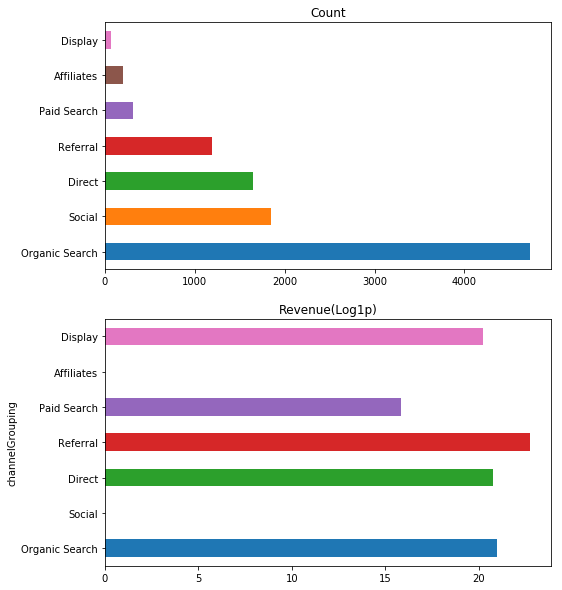

In [44]:
#df['channelGrouping'].fillna('NAN').value_counts().plot(kind='bar')
df['channelGrouping'] = df['channelGrouping'].fillna('NAN')
#fd1 = df['channelGrouping'].value_counts()
#trace0 = go.Bar(x = fig_data.index.tolist(), y = fig_data.tolist())
#data = [trace0]
#py.iplot(data)
#plt.subplot(1, 2, 1)
#fd1.plot(kind='bar')
#plt.subplot(1, 2, 2)
#fd2 = df.groupby('channelGrouping')[y_name].sum().apply(np.log1p)
#fd2 = fd2[fd1.index.tolist()]
#fd2.plot(kind='bar')
plot_bar(df, 'channelGrouping')

In [39]:
import math
df['visitId'].quantile(np.arange(0, 1.01, 0.1))

0.0    1.472799e+09
0.1    1.472858e+09
0.2    1.485465e+09
0.3    1.486181e+09
0.4    1.498206e+09
0.5    1.503212e+09
0.6    1.508192e+09
0.7    1.510342e+09
0.8    1.512065e+09
0.9    1.523781e+09
1.0    1.523862e+09
Name: visitId, dtype: float64

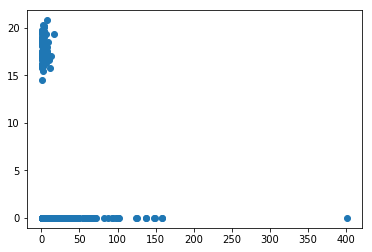

In [45]:
plt.scatter(df['visitNumber'].fillna(0), df[y_name + '_log'])

In [76]:
# map visit start time into local time
import googlemaps
from datetime import datetime
import json

#with open('.secret.json') as f:
#    # Setting up API key
#    pk = json.load(f)
    
# print(pk)
#gmaps = googlemaps.Client(key=pk['key'])

# 
# dir(gmaps)

In [ ]:
#res = gmaps.geocode('1600 Amphitheatre Parkway, Mountain View, CA')
#print(res)

#timez = gmaps.timezone(location=res[0]['geometry']['location'])
#print(timez)

In [71]:
#addr = df[['geoNetwork.city', 'geoNetwork.region', 'geoNetwork.country']].fillna('').apply(lambda x: ' '.join(x), axis=1)
#print(f"Empty addr count: {(addr == '').sum()}")

Empty addr count: 0


In [54]:
#addr.head()

0                          United States
1                          United States
2                              Australia
3    Buenos Aires Buenos Aires Argentina
4    Buenos Aires Buenos Aires Argentina
dtype: object

In [ ]:
#d = {}
#for c in addr.unique().tolist():
#    geo_res = gmaps.geocode(c)
#    timez = gmaps.timezone(location=geo_res[0]['geometry']['location'])
#    d[c] = timez

In [ ]:
# map back the hour


In [25]:
df['visitHour'] = df['visitStartTime'].dt.hour
df['visitDay'] = df['visitStartTime'].dt.day
df['visitDOW'] = df['visitStartTime'].dt.dayofweek
df['visitTimestamp'] = df['visitStartTime'].apply(lambda x: x.timestamp()).astype(int)
df[['visitStartTime', 'visitHour', 'visitDay', 'visitDOW', 'visitTimestamp']].head()

,visitStartTime,visitHour,visitDay,visitDOW,visitTimestamp
0,2016-09-03 00:34:02,0,3,5,1472862842
1,2017-02-03 21:35:41,21,3,4,1486157741
2,2016-09-02 14:01:47,14,2,4,1472824907
3,2016-09-02 18:35:36,18,2,4,1472841336
4,2016-09-02 19:13:26,19,2,4,1472843606


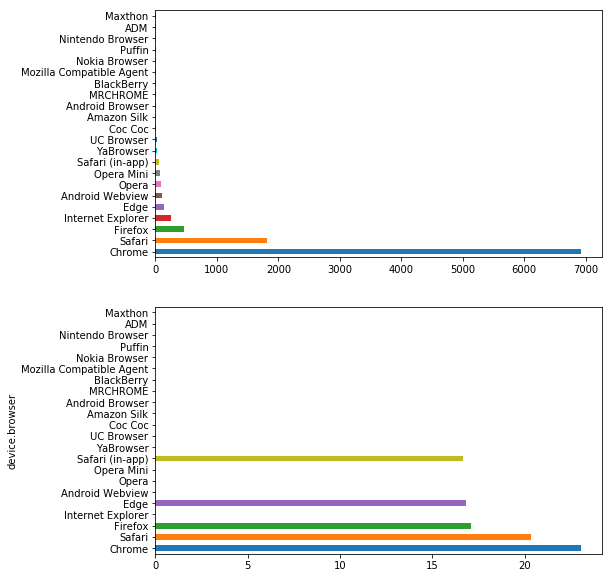

In [38]:
df['device.browser'] = df['device.browser'].fillna("NAN")
plot_bar(df, 'device.browser')

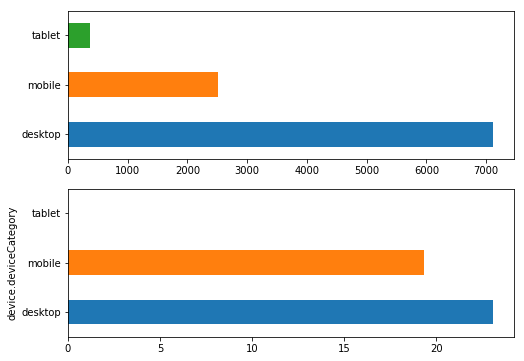

In [40]:
sc = 'device.deviceCategory'
df[sc] = df[sc].fillna("NAN")
plot_bar(df, sc, fig_size=(8, 6))

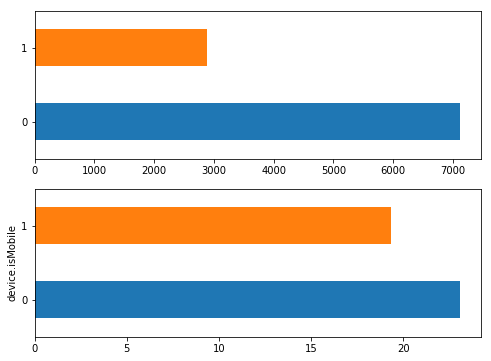

In [41]:
sc = 'device.isMobile'
df[sc] = df[sc].fillna("NAN")
plot_bar(df, sc, fig_size=(8, 6))

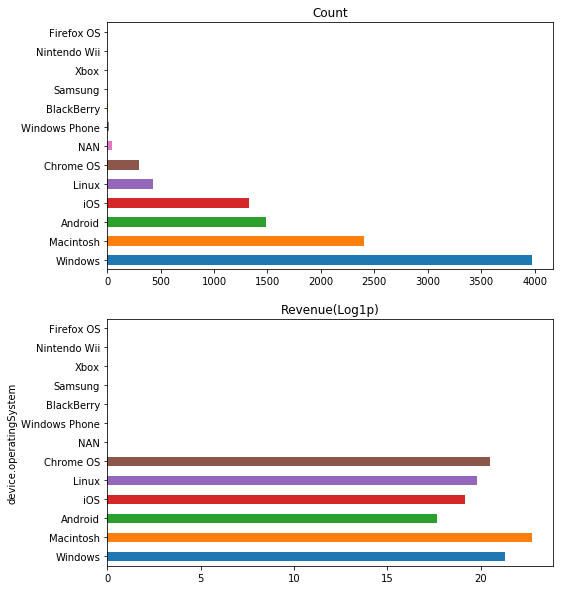

In [46]:
sc = 'device.operatingSystem'
df[sc] = df[sc].fillna("NAN")
plot_bar(df, sc)

In [62]:
sc = [c for c in df.columns.tolist() if c.startswith('geoNetwork')]
# print(sc)
for c in sc:
    vc = df[c].fillna('NAN').value_counts()
    qc = vc.quantile([0, 0.25, 0.5, 0.75, 1])
    qc = list(zip(qc.index.tolist(), qc.values.tolist()))
    print(f'Column: {c} category count: {len(vc)}, Quantile count: {qc}')
    print(vc.head(3))
    print("====" * 10)

Column: geoNetwork.city category count: 108, Quantile count: [(0.0, 4.0), (0.25, 8.75), (0.5, 18.0), (0.75, 39.0), (1.0, 6252.0)]
NAN              6252
Mountain View     493
New York          274
Name: geoNetwork.city, dtype: int64
Column: geoNetwork.continent category count: 6, Quantile count: [(0.0, 13.0), (0.25, 161.0), (0.5, 1110.5), (0.75, 2292.5), (1.0, 5235.0)]
Americas    5235
Europe      2375
Asia        2045
Name: geoNetwork.continent, dtype: int64
Column: geoNetwork.country category count: 138, Quantile count: [(0.0, 1.0), (0.25, 2.0), (0.5, 9.0), (0.75, 46.75), (1.0, 4274.0)]
United States     4274
India              531
United Kingdom     405
Name: geoNetwork.country, dtype: int64
Column: geoNetwork.metro category count: 21, Quantile count: [(0.0, 4.0), (0.25, 23.0), (0.5, 36.0), (0.75, 105.0), (1.0, 7806.0)]
NAN                                  7806
San Francisco-Oakland-San Jose CA    1103
New York NY                           274
Name: geoNetwork.metro, dtype: int64
Col

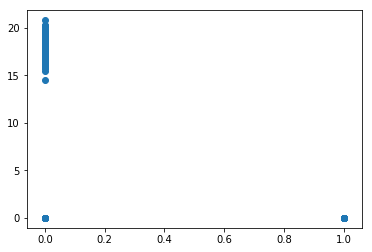

In [73]:
sc = "totals.bounces"
# df[sc].fillna(0).quantile(np.arange(0, 1.01, 0.25))
plt.scatter(df[sc].fillna(0), df[y_name+"_log"])
# df[[sc, y_name+"_log"]].head()

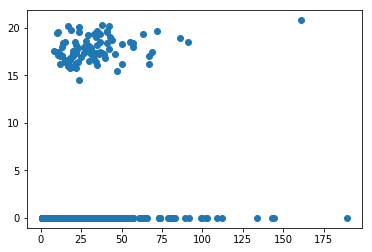

In [74]:
sc = "totals.hits"
plt.scatter(df[sc].fillna(0), df[y_name+"_log"])

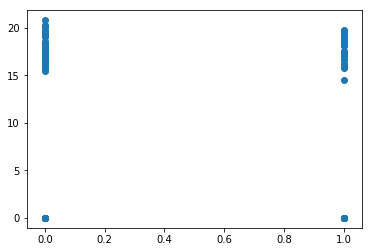

In [75]:
sc = "totals.newVisits"
plt.scatter(df[sc].fillna(0), df[y_name+"_log"])

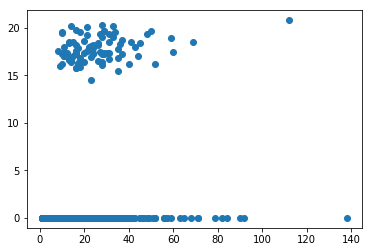

In [76]:
sc = "totals.pageviews"
plt.scatter(df[sc].fillna(0), df[y_name+"_log"])

In [81]:
print((df["totals.pageviews"] != df["totals.hits"]).sum() / df.shape[0])
df[['totals.pageviews', 'totals.hits']].corr()

0.1645


,totals.pageviews,totals.hits
totals.pageviews,1.000000,0.986301
totals.hits,0.986301,1.000000


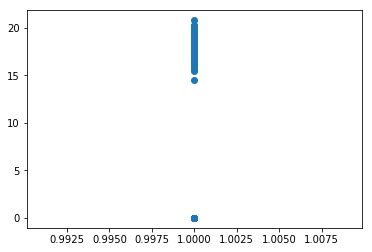

In [82]:
sc = "totals.visits"
plt.scatter(df[sc].fillna(0), df[y_name+"_log"])

In [89]:
# sc = 'trafficSource.adContent'
sc = [c for c in df.columns.tolist() if c.startswith('trafficSource')]
# print(sc)
for c in sc:
    vc = df[c].fillna('NAN').value_counts()
    qc = vc.quantile([0, 0.25, 0.5, 0.75, 1])
    qc = list(zip(qc.index.tolist(), qc.values.tolist()))
    print(f'Column: {c} category count: {len(vc)}, Quantile count: {qc}')
    print(vc.head(3))
    print("====" * 10)

Column: trafficSource.adContent category count: 18, Quantile count: [(0.0, 1.0), (0.25, 1.0), (0.5, 3.0), (0.75, 9.75), (1.0, 9849.0)]
NAN                              9849
Google Merchandise Collection      70
Full auto ad IMAGE ONLY            16
Name: trafficSource.adContent, dtype: int64
Column: trafficSource.adwordsClickInfo.adNetworkType category count: 2, Quantile count: [(0.0, 250.0), (0.25, 2625.0), (0.5, 5000.0), (0.75, 7375.0), (1.0, 9750.0)]
NAN              9750
Google Search     250
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: int64
Column: trafficSource.adwordsClickInfo.gclId category count: 236, Quantile count: [(0.0, 1.0), (0.25, 1.0), (0.5, 1.0), (0.75, 1.0), (1.0, 9747.0)]
NAN                                                                                           9747
CjwKEAjw-LLKBRCdhqmwtYmX93kSJAAORDM6K_vERGGpVExrh9ITmLoG1Ac8SdTNfUUUAU_WteWWUxoCKHrw_wcB         3
Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRLIyC4WoAABLm_mr4SI2fyuPXhlC4kX2y46BYNULOMoaAjKw8P8

In [42]:
df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'totals.transactionRevenue',
       'totals.transactionRevenue_log'],
   